# Riccati / Log-Derivative Method for Klein-Gordon

## Why This Method is Excellent for Scattering

The **log-derivative (Riccati)** method is considered the **gold standard** for scattering calculations because:

### The Key Idea
Instead of solving for φ(x) directly (which grows exponentially), solve for:
$$y(x) = \frac{\phi'(x)}{\phi(x)} = \frac{d}{dx}\ln\phi(x)$$

This is the **Riccati equation**, which stays bounded even when φ(x) diverges!

### Advantages
1. ✅ **No exponential growth** - y(x) stays bounded
2. ✅ **Single pass integration** - no matching needed
3. ✅ **Very stable numerically** - used in atomic/nuclear physics
4. ✅ **Direct phase extraction** - for scattering amplitudes

### The Riccati Equation
From $\phi'' = f(x)\phi$ we get:
$$y' = f(x) - y^2$$

This nonlinear ODE is much more stable than the original!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [3]:
# Riccati scattering model organized as a class (generic potential)
#
# Key idea: you provide V(x) as a Python function, plus the asymptotic values
# V_L = lim_{x->-∞} V(x) and V_R = lim_{x->+∞} V(x).
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Union

ArrayLike = Union[float, np.ndarray]

@dataclass
class RiccatiModel:
    # Physics parameters
    m: float

    # Potential API
    V: Callable[[ArrayLike], ArrayLike]
    V_L: float
    V_R: float
    potential_label: str = r'$V(x)$'

    # Numerics
    XMIN: float = -10.0
    XMAX: float = 10.0
    N_STEPS: int = 6000
    Y_MAX: float = 1e6
    EPS_DENOM: float = 1e-12

    def V_of_x(self, x: ArrayLike) -> ArrayLike:
        return self.V(x)

    @property
    def VL(self) -> float:
        return float(self.V_L)

    @property
    def VR(self) -> float:
        return float(self.V_R)

    @property
    def E_sr(self):
        return self.VR - self.m

    @property
    def E_prop(self):
        return self.VR + self.m

    def local_k(self, E, x):
        V = self.V_of_x(x)
        z = (E - V)**2 - self.m**2
        return np.sqrt(z + 0j)

    def asymptotic_k(self, E, V_asym):
        z = (E - V_asym)**2 - self.m**2
        k = np.sqrt(z + 0j)
        if abs(k.imag) < 1e-14:
            base = abs(k.real)
            sgn = 1.0 if (E - V_asym) >= 0 else -1.0
            return sgn * base + 0j
        return k

    def riccati_rhs(self, x, y, E):
        k = self.local_k(E, x)
        return -y*y - k*k

    def integrate_riccati(self, E):
        xR = self.XMAX
        xL = self.XMIN
        h = (xL - xR) / self.N_STEPS  # negative step
        kR = self.asymptotic_k(E, self.VR)
        y = 1j * kR
        x = xR
        for _ in range(self.N_STEPS):
            k1 = self.riccati_rhs(x,           y,             E)
            k2 = self.riccati_rhs(x + 0.5*h,   y + 0.5*h*k1,  E)
            k3 = self.riccati_rhs(x + 0.5*h,   y + 0.5*h*k2,  E)
            k4 = self.riccati_rhs(x + h,       y + h*k3,      E)
            y += (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
            x += h
            mag = abs(y)
            if mag > self.Y_MAX:
                y = y * (self.Y_MAX / mag)
        return y

    def scattering_coeffs(self, E):
        zL = (E - self.VL)**2 - self.m**2
        if zL <= 0:
            return 0.0, 0.0
        yL = self.integrate_riccati(E)
        kL = self.asymptotic_k(E, self.VL)
        xL = self.XMIN
        phase_factor = np.exp(2j * kL * xL)
        denom = yL + 1j*kL
        if abs(denom) < self.EPS_DENOM:
            denom = denom + self.EPS_DENOM
        R_amp = phase_factor * (1j*kL - yL) / denom
        R_prob = np.abs(R_amp)**2
        zR = (E - self.VR)**2 - self.m**2
        if zR <= 0:
            return 1.0, 0.0
        T_signed = 1.0 - R_prob
        return float(R_prob), float(T_signed)

    def compute_RT_spectrum(self, E_min=0.0, E_max=15.0, nE=1000):
        E_vals = np.linspace(E_min, E_max, nE)
        R_vals = np.empty_like(E_vals, dtype=float)
        T_vals = np.empty_like(E_vals, dtype=float)
        for i, E in enumerate(E_vals):
            R_vals[i], T_vals[i] = self.scattering_coeffs(E)
        return E_vals, R_vals, T_vals

    def plot_potential(self, num_points=500):
        x = np.linspace(self.XMIN, self.XMAX, num_points)
        Vx = self.V_of_x(x)
        plt.figure(figsize=(7,4))
        plt.plot(x, Vx)
        plt.title(self.potential_label)
        plt.xlabel('x')
        plt.ylabel('V(x)')
        plt.grid(True, alpha=0.3)
        plt.savefig('figures/potential.png')
        plt.show()

# Helper to print conservation checks
def print_conservation(E_vals, R_vals, T_vals, E_sr, E_prop):
    RT_sum = R_vals + T_vals
    print('\nConservation check:')
    print(f'Average R+T = {np.nanmean(RT_sum):.6f}')
    print(f'Std(R+T) = {np.nanstd(RT_sum):.6f}')
    print(f'Max |R+T-1| = {np.nanmax(np.abs(RT_sum - 1)):.6f}')
    sr_mask = R_vals > 1.01
    neg_T_mask = T_vals < -0.01
    if np.any(sr_mask):
        print(f'\n✓ Found {np.sum(sr_mask)} energies with R > 1')
        print(f'  Max R = {np.nanmax(R_vals):.4f}')
    if np.any(neg_T_mask):
        print(f'✓ Found {np.sum(neg_T_mask)} energies with T < 0')
        print(f'  Min T = {np.nanmin(T_vals):.4f}')
    print('\nTheoretical superradiance window:')
    print(f'  E_sr = V_R - m = {E_sr:.4f}')
    print(f'  E_prop = V_R + m = {E_prop:.4f}')

## CASE 1 (class-based)

This section defines a concrete potential function $V(x)$ and then computes $R(E)$ and $T(E)$ for that case.
(All executable code is in the Python cells below.)

In [4]:
# Setup Case 1 model: V(x) = a * exp(b * tanh(c x))
m = 1.0
a, b, c = 2.0, 2.0, 3.0
V1 = lambda x: a * np.exp(b * np.tanh(c * x))
V1_L = a * np.exp(-b)
V1_R = a * np.exp(+b)

model1 = RiccatiModel(
    m=m,
    V=V1,
    V_L=V1_L,
    V_R=V1_R,
    potential_label=r'$V(x)=a\,e^{b\tanh(cx)}$',
    XMIN=-10.0, XMAX=10.0, N_STEPS=6000
)

In [5]:
# Compute spectrum (Case 1)
E_vals, R_vals, T_vals = model1.compute_RT_spectrum(
    E_min=1.0, E_max=20.0, nE=300
)

# Conservation check
print_conservation(E_vals, R_vals, T_vals, model1.E_sr, model1.E_prop)



Conservation check:
Average R+T = 0.983333
Std(R+T) = 0.128019
Max |R+T-1| = 1.000000

✓ Found 196 energies with R > 1
  Max R = 2.4062
✓ Found 196 energies with T < 0
  Min T = -1.4062

Theoretical superradiance window:
  E_sr = V_R - m = 13.7781
  E_prop = V_R + m = 15.7781


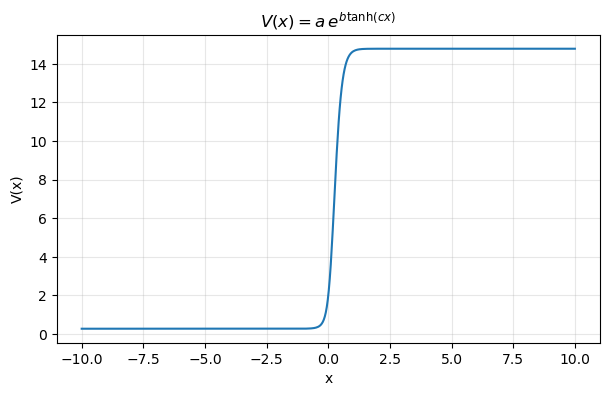

In [7]:
# Plot potential for Case 1
model1.plot_potential(num_points=500)


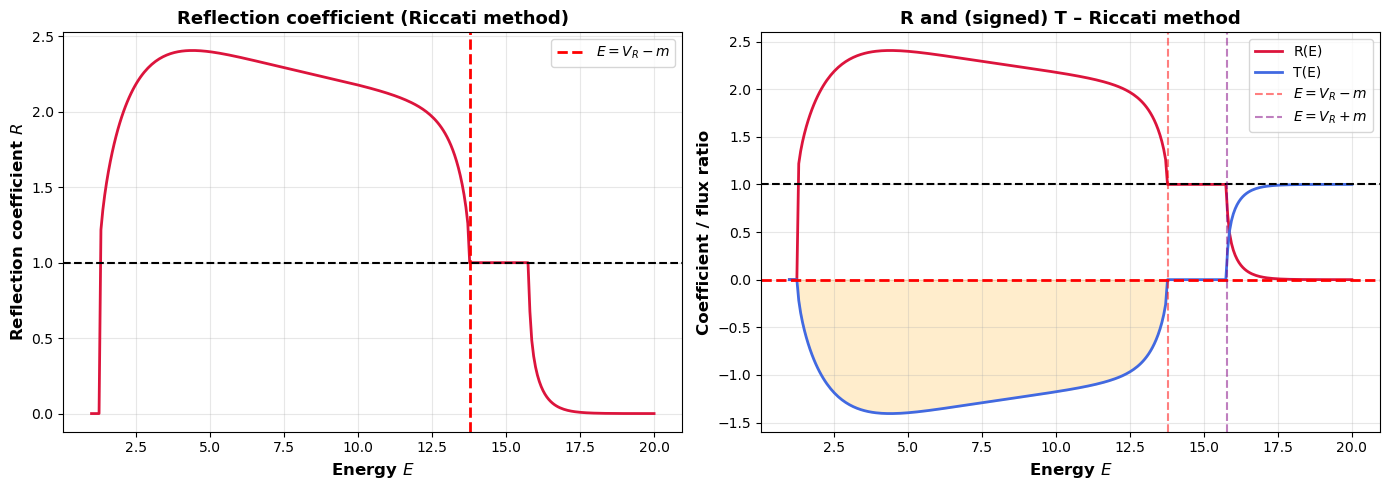

In [56]:
# Reflection and signed transmission plots (Case 1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(E_vals, R_vals, linewidth=2, color='crimson')
ax.axvline(model1.E_sr, linestyle='--', color='red', linewidth=2, label=r'$E = V_R - m$')
ax.axhline(1.0, linestyle='--', color='black', linewidth=1.5)
ax.set_xlabel(r'Energy $E$', fontsize=12, fontweight='bold')
ax.set_ylabel(r'Reflection coefficient $R$', fontsize=12, fontweight='bold')
ax.set_title('Reflection coefficient (Riccati method)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

ax = axes[1]
ax.plot(E_vals, R_vals, linewidth=2, color='crimson', label='R(E)', linestyle='-')
ax.plot(E_vals, T_vals, linewidth=2, color='royalblue', label='T(E)', linestyle='-')
ax.axhline(0.0, color='red', linewidth=2, linestyle='--')
ax.axhline(1.0, color='black', linewidth=1.5, linestyle='--')
ax.axvline(model1.E_sr, linestyle='--', color='red', linewidth=1.5, alpha=0.5, label=r'$E = V_R - m$')
ax.axvline(model1.E_prop, linestyle='--', color='purple', linewidth=1.5, alpha=0.5, label=r'$E = V_R + m$')
ax.fill_between(E_vals, 0, T_vals, where=(T_vals < 0), alpha=0.2, color='orange')
ax.set_xlabel(r'Energy $E$', fontsize=12, fontweight='bold')
ax.set_ylabel('Coefficient / flux ratio', fontsize=12, fontweight='bold')
ax.set_title('R and (signed) T – Riccati method', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


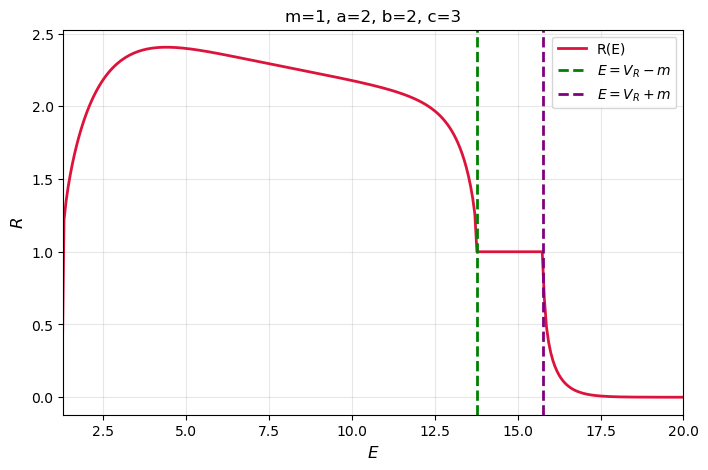

In [57]:
plt.figure(figsize=(8,5))
plt.plot(E_vals, R_vals, linewidth=2, color='crimson', label='R(E)')
plt.axvline(model1.E_sr, linestyle='--', color='green', linewidth=2, label=r'$E = V_R - m$')
plt.axvline(model1.E_prop, linestyle='--', color='purple', linewidth=2, label=r'$E = V_R + m$')
plt.legend()
plt.xlabel(r'$E$', fontsize=12, fontweight='bold')
plt.xlim(1.3,20)
plt.title("m=1, a=2, b=2, c=3")
plt.ylabel(r'$R$', fontsize=12, fontweight='bold')
plt.grid(True,alpha=0.3)
plt.savefig('figures/RvE-c1.png', dpi=300)
plt.show()


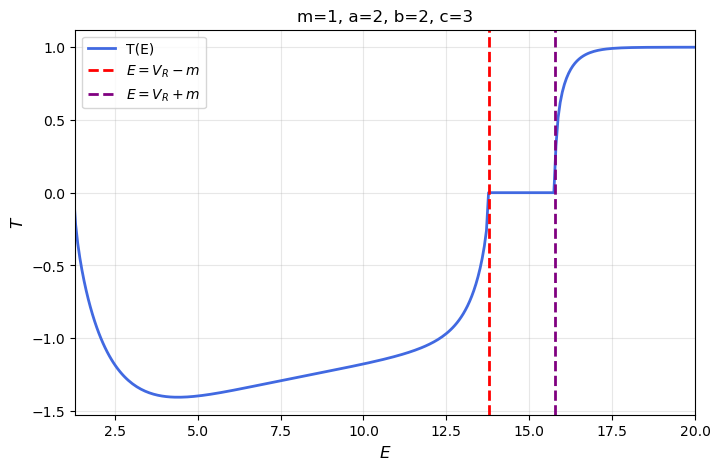

In [58]:
plt.figure(figsize=(8,5))
plt.plot(E_vals, T_vals, linewidth=2, color='royalblue', label='T(E)')
plt.axvline(model1.E_sr, linestyle='--', color='red', linewidth=2, label=r'$E = V_R - m$')
plt.axvline(model1.E_prop, linestyle='--', color='purple', linewidth=2, label=r'$E = V_R + m$')
plt.legend()
plt.xlabel(r'$E$', fontsize=12, fontweight='bold')
plt.xlim(1.3,20)
plt.ylabel(r'$T$', fontsize=12, fontweight='bold')
plt.title("m=1, a=2, b=2, c=3")
plt.grid(True,alpha=0.3)
plt.savefig('figures/TvE-c1.png', dpi=300)
plt.show()


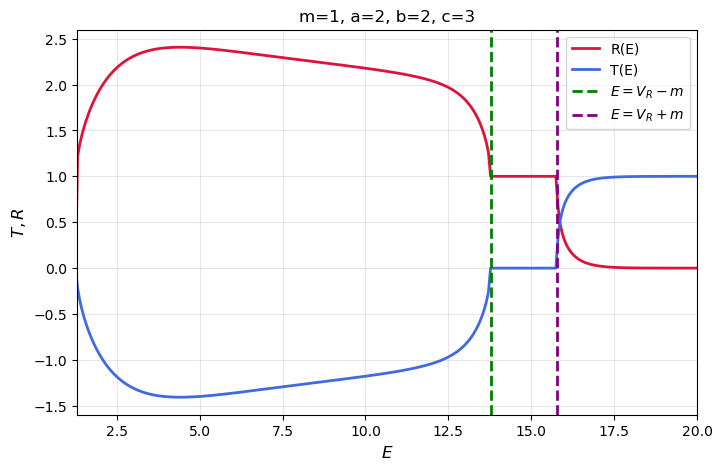

In [59]:
plt.figure(figsize=(8,5))
plt.plot(E_vals, R_vals, linewidth=2, color='crimson', label='R(E)')
plt.plot(E_vals, T_vals, linewidth=2, color='royalblue', label='T(E)')
plt.axvline(model1.E_sr, linestyle='--', color='green', linewidth=2, label=r'$E = V_R - m$')
plt.axvline(model1.E_prop, linestyle='--', color='purple', linewidth=2, label=r'$E = V_R + m$')
plt.legend()
plt.xlabel(r'$E$', fontsize=12, fontweight='bold')
plt.xlim(1.3,20)
plt.ylabel(r'$T, R$', fontsize=12, fontweight='bold')
plt.title("m=1, a=2, b=2, c=3")
plt.grid(True,alpha=0.3)
plt.savefig('figures/R-TvE-c1.png', dpi=300)
plt.show()


## CASE 2 (class-based)

Same workflow as Case 1, just with different parameters for the potential.
(Executable code is in the Python cells below.)

In [8]:
# Setup Case 2 model: V(x) = a * exp(b * tanh(c x))
m = 1.0
a, b, c = 5.0, 1.0, 6.0
V2 = lambda x: a * np.exp(b * np.tanh(c * x))
V2_L = a * np.exp(-b)
V2_R = a * np.exp(+b)

model2 = RiccatiModel(
    m=m,
    V=V2,
    V_L=V2_L,
    V_R=V2_R,
    potential_label=r'$V(x)=a\,e^{b\tanh(cx)}$',
    XMIN=-10.0, XMAX=10.0, N_STEPS=6000
)

In [9]:
E_vals, R_vals, T_vals = model2.compute_RT_spectrum(
    E_min=0.0, E_max=20.0, nE=300
)

RT_sum = R_vals + T_vals
print(f"\nConservation check:")
print(f"Average R+T = {np.nanmean(RT_sum):.6f}")
print(f"Std(R+T) = {np.nanstd(RT_sum):.6f}")
print(f"Max |R+T-1| = {np.nanmax(np.abs(RT_sum - 1)):.6f}")

sr_mask = R_vals > 1.01
neg_T_mask = T_vals < -0.01

if np.any(sr_mask):
    print(f"\n✓ Found {np.sum(sr_mask)} energies with R > 1")
    print(f"  Max R = {np.nanmax(R_vals):.4f}")
if np.any(neg_T_mask):
    print(f"✓ Found {np.sum(neg_T_mask)} energies with T < 0")
    print(f"  Min T = {np.nanmin(T_vals):.4f}")

print(f"\nTheoretical superradiance window:")
print(f"  E_sr = VR - m = {model2.E_sr:.4f}")
print(f"  E_prop = VR + m = {model2.E_prop:.4f}")
print("="*70)


Conservation check:
Average R+T = 0.900000
Std(R+T) = 0.300000
Max |R+T-1| = 1.000000

✓ Found 146 energies with R > 1
  Max R = 3.3028
✓ Found 146 energies with T < 0
  Min T = -2.3028

Theoretical superradiance window:
  E_sr = VR - m = 12.5914
  E_prop = VR + m = 14.5914


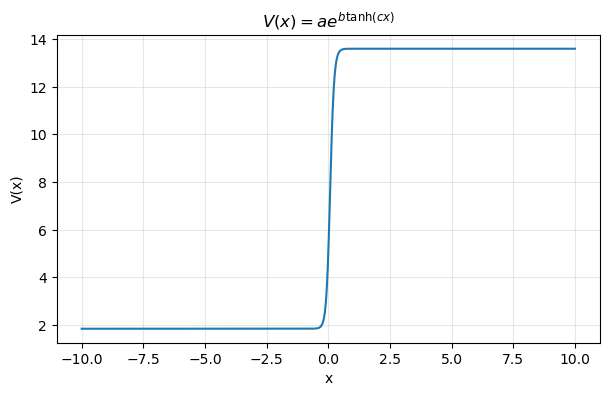

In [7]:
# Plot potential for Case 2
model2.plot_potential(num_points=500)


In [ ]:
# Optional: recompute spectrum for extended range
# E_vals, R_vals, T_vals = model2.compute_RT_spectrum(E_min=0.0, E_max=30.0, nE=300)

# Optional: conservation and thresholds (uses shared helper)
# print_conservation(E_vals, R_vals, T_vals, model2.E_sr, model2.E_prop)


Conservation check:
Average R+T = 0.933333
Std(R+T) = 0.249444
Max |R+T-1| = 1.000000

✓ Found 97 energies with R > 1
  Max R = 3.3027
✓ Found 97 energies with T < 0
  Min T = -2.3027

Theoretical superradiance window:
  E_sr = VR - m = 12.5914
  E_prop = VR + m = 14.5914


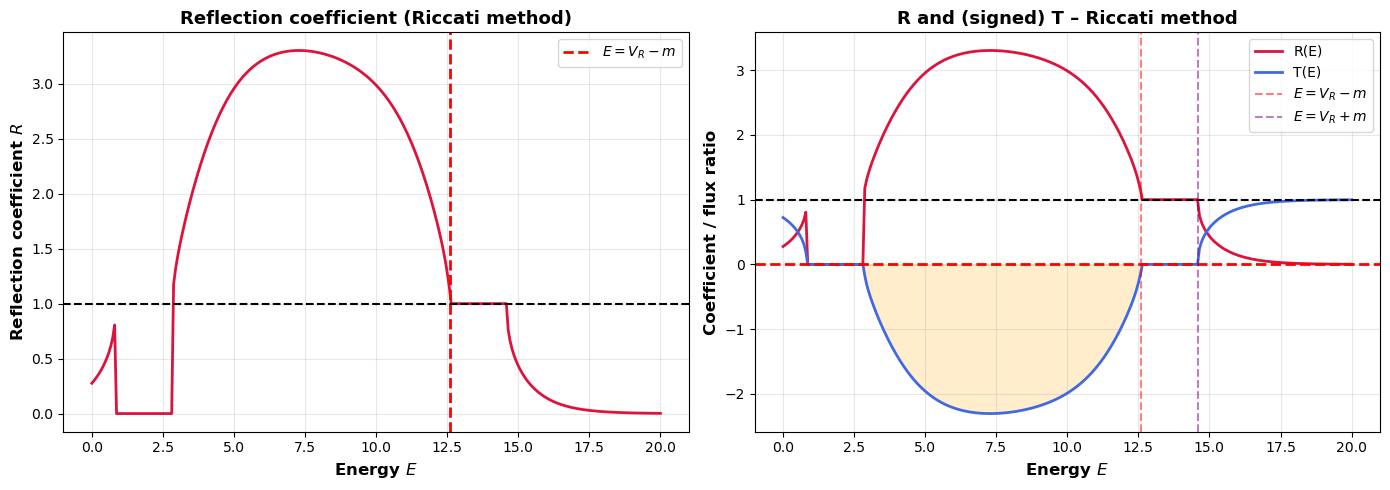

In [8]:
# Reflection and signed transmission plots (Case 2)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(E_vals, R_vals, linewidth=2, color='crimson')
ax.axvline(model2.E_sr, linestyle='--', color='red', linewidth=2, label=r'$E = V_R - m$')
ax.axhline(1.0, linestyle='--', color='black', linewidth=1.5)
ax.set_xlabel(r'Energy $E$', fontsize=12, fontweight='bold')
ax.set_ylabel(r'Reflection coefficient $R$', fontsize=12, fontweight='bold')
ax.set_title('Reflection coefficient (Riccati method)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

ax = axes[1]
ax.plot(E_vals, R_vals, linewidth=2, color='crimson', label='R(E)', linestyle='-')
ax.plot(E_vals, T_vals, linewidth=2, color='royalblue', label='T(E)', linestyle='-')
ax.axhline(0.0, color='red', linewidth=2, linestyle='--')
ax.axhline(1.0, color='black', linewidth=1.5, linestyle='--')
ax.axvline(model2.E_sr, linestyle='--', color='red', linewidth=1.5, alpha=0.5, label=r'$E = V_R - m$')
ax.axvline(model2.E_prop, linestyle='--', color='purple', linewidth=1.5, alpha=0.5, label=r'$E = V_R + m$')
ax.fill_between(E_vals, 0, T_vals, where=(T_vals < 0), alpha=0.2, color='orange')
ax.set_xlabel(r'Energy $E$', fontsize=12, fontweight='bold')
ax.set_ylabel('Coefficient / flux ratio', fontsize=12, fontweight='bold')
ax.set_title('R and (signed) T – Riccati method', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


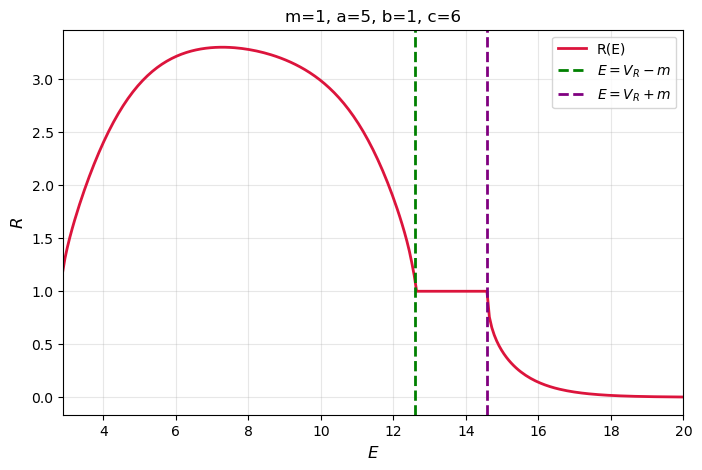

In [9]:
plt.figure(figsize=(8,5))
plt.plot(E_vals, R_vals, linewidth=2, color='crimson', label='R(E)')
plt.axvline(model2.E_sr, linestyle='--', color='green', linewidth=2, label=r'$E = V_R - m$')
plt.axvline(model2.E_prop, linestyle='--', color='purple', linewidth=2, label=r'$E = V_R + m$')
plt.legend()
plt.xlabel(r'$E$', fontsize=12, fontweight='bold')
plt.xlim(2.9,20)
plt.ylabel(r'$R$', fontsize=12, fontweight='bold')
plt.title("m=1, a=5, b=1, c=6") 
plt.grid(True,alpha=0.3)
plt.savefig('figures/RvE-c2.png', dpi=300)
plt.show()


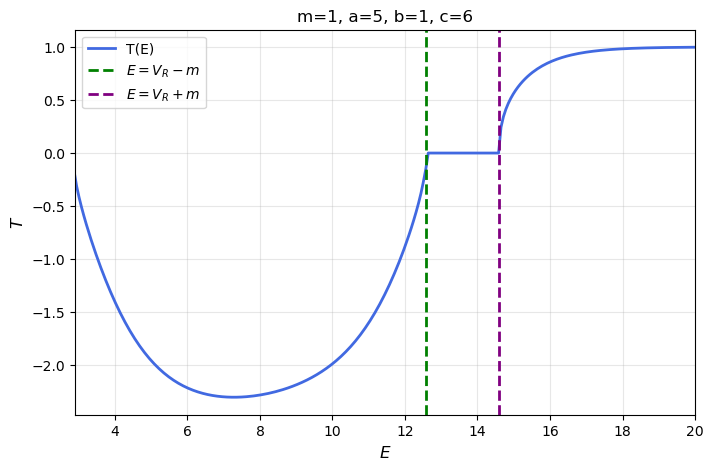

In [49]:
plt.figure(figsize=(8,5))
plt.plot(E_vals, T_vals, linewidth=2, color='royalblue', label='T(E)')
plt.axvline(model2.E_sr, linestyle='--', color='green', linewidth=2, label=r'$E = V_R - m$')
plt.axvline(model2.E_prop, linestyle='--', color='purple', linewidth=2, label=r'$E = V_R + m$')
plt.legend()
plt.xlabel(r'$E$', fontsize=12, fontweight='bold')
plt.xlim(2.9,20)
plt.ylabel(r'$T$', fontsize=12, fontweight='bold')
plt.grid(True,alpha=0.3)
plt.title("m=1, a=5, b=1, c=6")
plt.savefig('figures/TvE-c2.png', dpi=300)
plt.show()


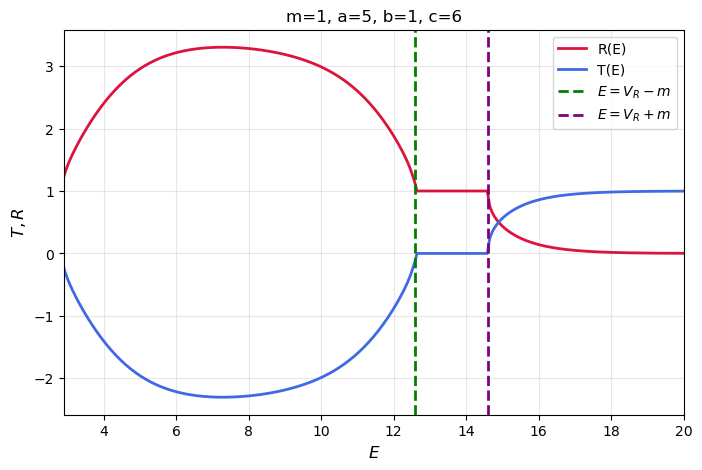

In [11]:
plt.figure(figsize=(8,5))
plt.plot(E_vals, R_vals, linewidth=2, color='crimson', label='R(E)')
plt.plot(E_vals, T_vals, linewidth=2, color='royalblue', label='T(E)')
plt.axvline(model2.E_sr, linestyle='--', color='green', linewidth=2, label=r'$E = V_R - m$')
plt.axvline(model2.E_prop, linestyle='--', color='purple', linewidth=2, label=r'$E = V_R + m$')
plt.legend()
plt.xlabel(r'$E$', fontsize=12, fontweight='bold')
plt.xlim(2.9,20)
plt.ylabel(r'$T, R$', fontsize=12, fontweight='bold')
plt.title("m=1, a=5, b=1, c=6")
plt.grid(True,alpha=0.3)

plt.savefig('figures/R-TvE-c2.png', dpi=300)
plt.show()


## Using the RiccatiModel class
This notebook now uses a reusable `RiccatiModel` class to avoid copying the entire model for each case.

- Configure a case by setting `(m, a, b, c, XMIN, XMAX, N_STEPS)`.
- Call `compute_RT_spectrum(E_min, E_max, nE)` to get `E_vals, R_vals, T_vals`.
- Use `plot_potential()` to visualize `V(x)`.
- `E_sr` and `E_prop` are available as properties for threshold markers.

Example:
```python
model = RiccatiModel(m=1.0, a=3.0, b=1.5, c=4.0)
E_vals, R_vals, T_vals = model.compute_RT_spectrum(E_min=0.0, E_max=25.0, nE=400)
```

## Regions

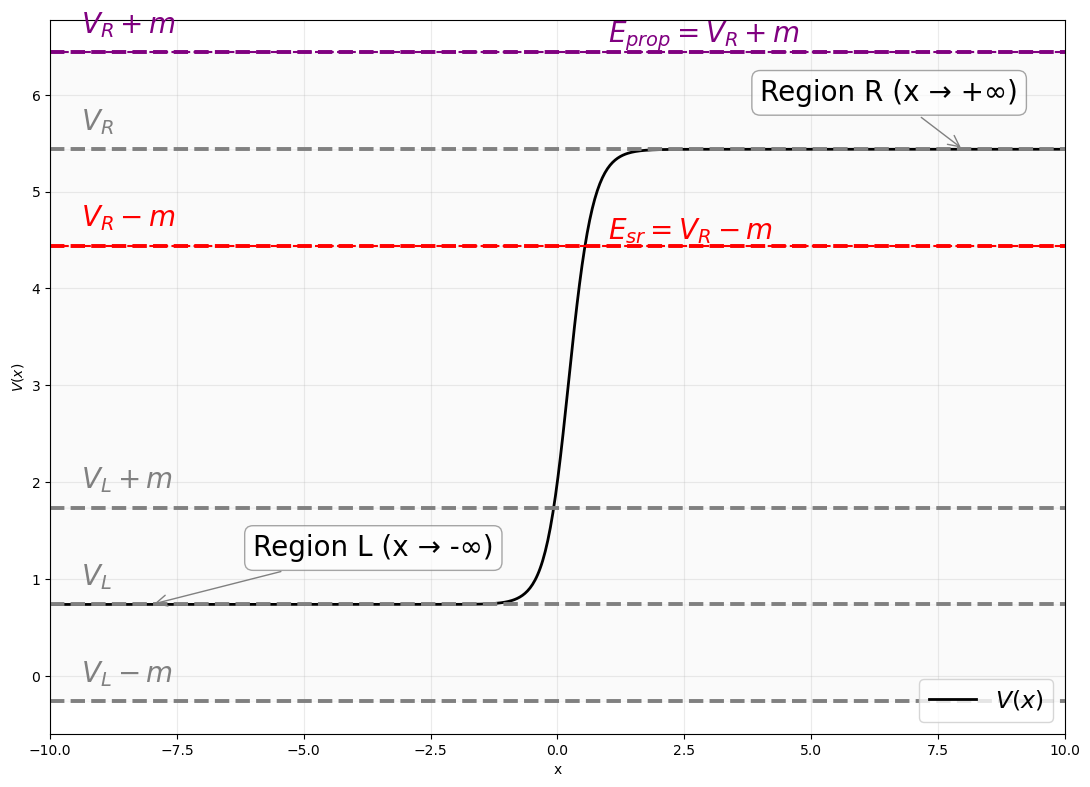

In [16]:
# Enhanced schematic: shaded regions and legend
import numpy as np
import matplotlib.pyplot as plt

# Choose which model to illustrate (Case 1 by default)
model = model1  # set to model2 if desired

# x-grid and potential
x = np.linspace(model.XMIN, model.XMAX, 800)
Vx = model.V_of_x(x)
VL, VR = model.VL, model.VR
m = model.m
E_sr, E_prop = model.E_sr, model.E_prop

# Reference levels and labels
ref_levels = [
    (VL - m, r"$V_L - m$", 'gray'),
    (VL,     r"$V_L$",      'gray'),
    (VL + m, r"$V_L + m$", 'gray'),
    (VR - m, r"$V_R - m$", 'red'),
    (VR,     r"$V_R$",      'gray'),
    (VR + m, r"$V_R + m$", 'purple'),
]

fig, ax = plt.subplots(figsize=(11,8))
ax.plot(x, Vx, color='black', linewidth=2, label=r'$V(x)$')
ax.set_xlabel('x')
ax.set_ylabel(r'$V(x)$')
#ax.set_title('Potential with shaded reference regions')
ax.grid(True, alpha=0.25)
ax.set_xlim(-10,10)
# Shade bands between adjacent levels to mimic regions
# Sort levels by value
ys = sorted([y for y, _, _ in ref_levels])
for y_low, y_high in zip(ys[:-1], ys[1:]):
    ax.fill_between(x, y_low, y_high, color='lightgray', alpha=0.11)

# Draw dashed reference lines with labels
x_text = x.min() + 0.03*(x.max()-x.min())
for y, label, color in ref_levels:
    style = '--'
    lw = 2.8
    ax.axhline(y, color=color, linestyle=style, linewidth=lw)
    ax.text(x_text, y + 0.02*(ys[-1]-ys[0]), label, fontsize=20, color=color, va='bottom')

# Threshold lines (right-side annotations)
ax.axhline(E_sr, color='red', linestyle='--', linewidth=1.5)
ax.axhline(E_prop, color='purple', linestyle='--', linewidth=1.5)
ax.text(x.max() - 0.45*(x.max()-x.min()), E_sr, r'$E_{sr}=V_R-m$', color='red', fontsize=20, va='bottom')
ax.text(x.max() - 0.45*(x.max()-x.min()), E_prop, r'$E_{prop}=V_R+m$', color='purple', fontsize=20, va='bottom')

# Region annotations (asymptotic)
ax.annotate('Region L (x → -∞)', xy=(x.min()+0.1*(x.max()-x.min()), VL),
            xytext=(x.min()+0.2*(x.max()-x.min()), VL + 0.5),
            arrowprops=dict(arrowstyle='->', color='gray'),
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7),
            fontsize=20)
ax.annotate('Region R (x → +∞)', xy=(x.max()-0.1*(x.max()-x.min()), VR),
            xytext=(x.max()-0.3*(x.max()-x.min()), VR + 0.5),
            arrowprops=dict(arrowstyle='->', color='gray'),
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7),
            fontsize=20)

# Legend
ax.legend(loc=4,fontsize=17)

plt.tight_layout()
plt.savefig('figures/potential_regions_schematic_v2.png', dpi=300)
plt.show()

# TAN-Hyperbolic-Potential

In [12]:

m = 1.0
a, b = 5, 2.0
V1 = lambda x: a  * np.tanh(b * x)
V1_L = -a
V1_R = a

model3 = RiccatiModel(
    m=m,
    V=V1,
    V_L=V1_L,
    V_R=V1_R,
    potential_label=r'$V(x)=a\,e^{b\tanh(cx)}$',
    XMIN=-10.0, XMAX=10.0, N_STEPS=6000
)

In [13]:
# Compute spectrum (Case 1)
E_vals, R_vals, T_vals = model3.compute_RT_spectrum(
    E_min=1.0, E_max=20.0, nE=300
)

# Conservation check
print_conservation(E_vals, R_vals, T_vals, model1.E_sr, model1.E_prop)


Conservation check:
Average R+T = 1.000000
Std(R+T) = 0.000000
Max |R+T-1| = 0.000000

✓ Found 48 energies with R > 1
  Max R = 1.9861
✓ Found 48 energies with T < 0
  Min T = -0.9861

Theoretical superradiance window:
  E_sr = V_R - m = 4.0000
  E_prop = V_R + m = 6.0000


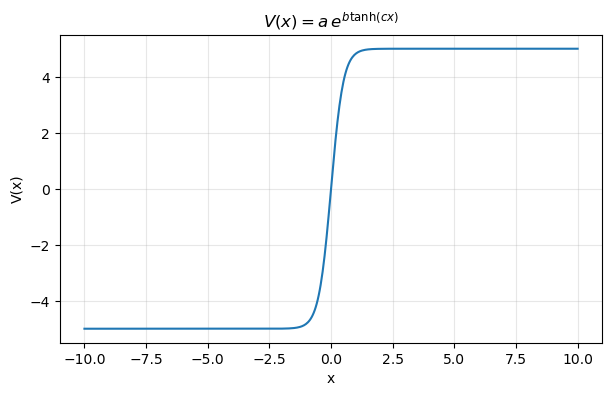

In [14]:
model3.plot_potential(num_points=500)

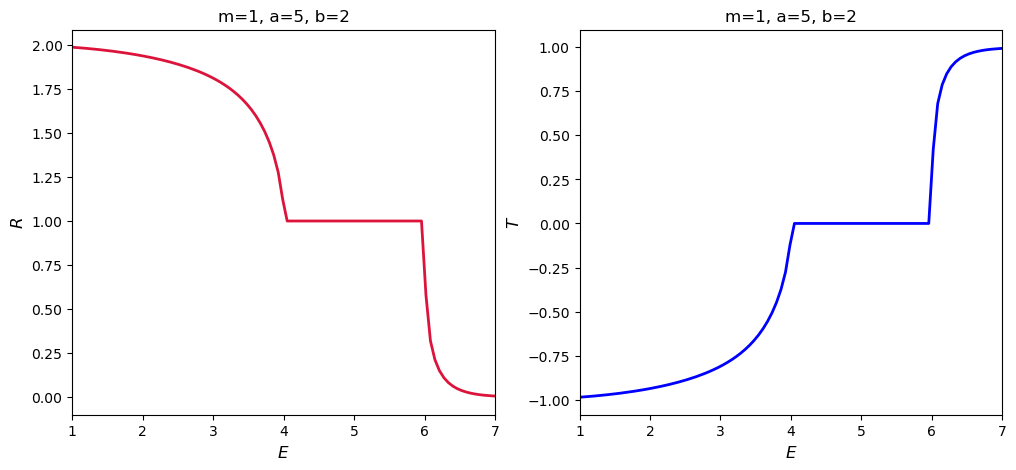

In [22]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(E_vals, R_vals, linewidth=2, color='crimson', label='R(E)')
plt.xlabel(r'$E$', fontsize=12, fontweight='bold')
plt.ylabel(r'$R$', fontsize=12, fontweight='bold')
plt.title("m=1, a=5, b=2")
plt.xlim(1,7)
plt.subplot(1,2,2)  
plt.plot(E_vals, T_vals, linewidth=2, color='blue', label='T(E)')
plt.xlabel(r'$E$', fontsize=12, fontweight='bold')
plt.ylabel(r'$T$', fontsize=12, fontweight='bold')
plt.title("m=1, a=5, b=2")
plt.xlim(1,7)
plt.show()

In [25]:
m = 1.0
a, b = 5, 50
V1 = lambda x: a  * np.tanh(b * x)
V1_L = -a
V1_R = a

model4 = RiccatiModel(
    m=m,
    V=V1,
    V_L=V1_L,
    V_R=V1_R,
    potential_label=r'$V(x)=a\,e^{b\tanh(cx)}$',
    XMIN=-10.0, XMAX=10.0, N_STEPS=6000
)

In [26]:
# Compute spectrum (Case 1)
E_vals, R_vals, T_vals = model4.compute_RT_spectrum(
    E_min=1.0, E_max=20.0, nE=300
)

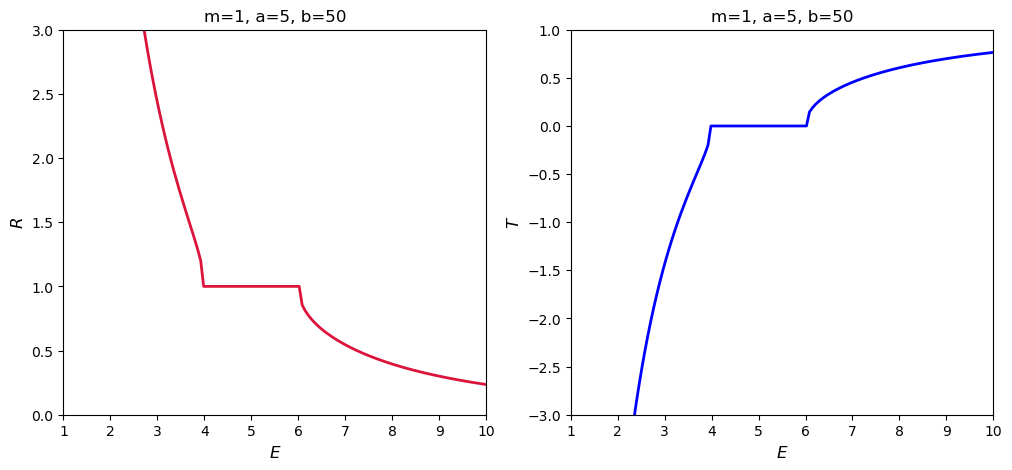

In [32]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(E_vals, R_vals, linewidth=2, color='crimson', label='R(E)')
plt.xlabel(r'$E$', fontsize=12, fontweight='bold')
plt.ylabel(r'$R$', fontsize=12, fontweight='bold')
plt.title("m=1, a=5, b=50")
plt.xlim(1,10)
plt.ylim(-0,3)
plt.subplot(1,2,2)  
plt.plot(E_vals, T_vals, linewidth=2, color='blue', label='T(E)')
plt.xlabel(r'$E$', fontsize=12, fontweight='bold')
plt.ylabel(r'$T$', fontsize=12, fontweight='bold')
plt.title("m=1, a=5, b=50")
plt.xlim(1,10)
plt.ylim(-3,1)
plt.show()